In [72]:
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer

path = '/home/codeforces_sft/eval_outputs/base_model/grader_logs.json'
with open(path, 'r') as f:
    grader_logs = json.load(f)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", cache_dir="/root/hf/models/",download_mode="reuse_if_exists")



In [35]:
print(grader_logs['2063/A'].keys())

dict_keys(['ratings', 'tags', 'attempt_0', 'attempt_1', 'attempt_2', 'attempt_3', 'attempt_4', 'attempt_5', 'attempt_6', 'attempt_7'])


In [ ]:
def calculate_pass_k(grader_logs, k_values=[1, 2, 3, 4, 5, 6, 7, 8]):
    """
    Calculate pass@k metrics for each k in k_values.
    Pass@k means: out of k attempts, what's the probability that at least one succeeds?
    """
    results = {}
    problem_results = []
    
    for problem_id, problem_data in grader_logs.items():
            
        problem_result = {'problem_id': problem_id}
        
        # Get acceptance status for each attempt
        attempts = []
        for i in range(8):  # 8 attempts per problem
            tokens = len(tokenizer.encode(problem_data[f'attempt_{i}']['response']))
            accepted = problem_data[f'attempt_{i}'].get('accepted', False)
            attempts.append({'accepted': accepted, 'tokens': tokens})

        problem_result['attempts'] = attempts
        
        # Calculate pass@k for each k
        for k in k_values:
            # Check if any of the first k attempts succeeded
            pass_at_k = any([attempt['accepted'] for attempt in attempts[:k]])
            problem_result[f'pass@{k}'] = pass_at_k
            problem_result[f'pass@{k}_tokens'] = sum([attempt['tokens'] for attempt in attempts[:k]])
            
        problem_results.append(problem_result)
    
    # Calculate overall statistics
    total_problems = len(problem_results)
    
    for k in k_values:
        passed_problems = sum(1 for p in problem_results if p[f'pass@{k}'])
        accuracy = passed_problems / total_problems if total_problems > 0 else 0
        results[f'pass@{k}'] = {
            'passed': passed_problems,
            'total': total_problems,
            'accuracy': accuracy
        }
    
    return results, problem_results




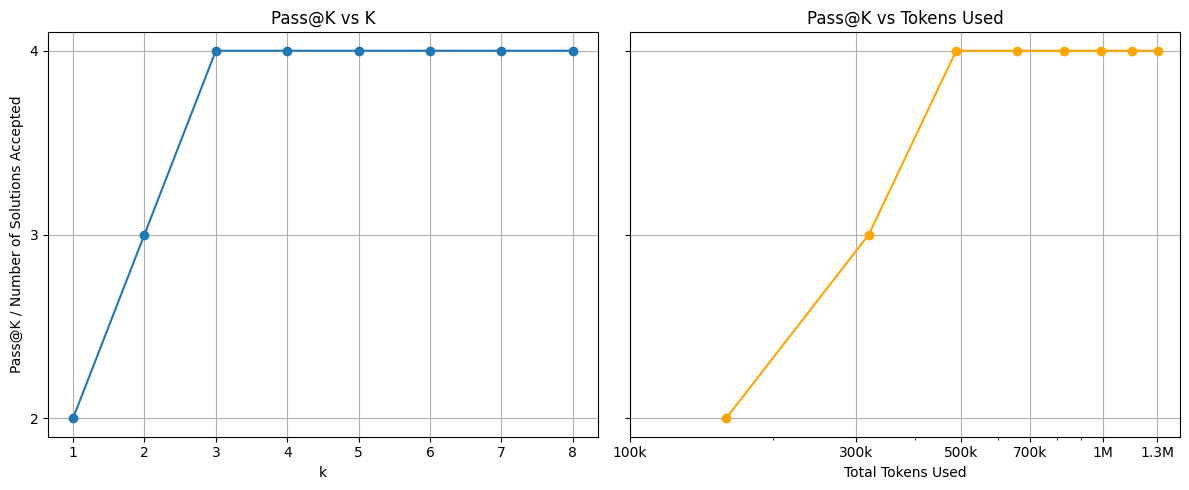

In [74]:
# Calculate pass@k metrics
pass_at_k_results, problem_details = calculate_pass_k(grader_logs)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter

ks = [1, 2, 3, 4, 5, 6, 7, 8]
num_solved = [pass_at_k_results[f'pass@{k}']['passed'] for k in ks]
tokens_used = []
for k in ks:
    # sum tokens for all problems for pass@k
    tokens_sum = sum(p[f'pass@{k}_tokens'] for p in problem_details)
    tokens_used.append(tokens_sum)

def int_formatter(x, pos):
    return f"{int(x)}"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].plot(ks, num_solved, marker='o')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Pass@K / Number of Solutions Accepted')
axes[0].set_title('Pass@K vs K')
axes[0].grid(True)
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].yaxis.set_major_formatter(FuncFormatter(int_formatter))

axes[1].plot(tokens_used, num_solved, marker='o', color='orange')
axes[1].set_xlabel('Total Tokens Used')
# axes[1].set_ylabel('# Problems Solved')
axes[1].set_xscale('log', base=10)
axes[1].set_title('Pass@K vs Tokens Used')
axes[1].grid(True)
axes[1].set_xticks([100000,300000,500000,700000,1000000,1300000])
axes[1].set_xticklabels(['100k','300k','500k','700k','1M','1.3M'])
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_formatter(FuncFormatter(int_formatter))

plt.tight_layout()
plt.show()

In [75]:
#failure mode analysis
all_logs = []
for problem_id in grader_logs:
    ratings = grader_logs[problem_id]['ratings']
    tags = grader_logs[problem_id]['tags']
    for i in range(8):
        accepted = grader_logs[problem_id][f'attempt_{i}']['accepted']
        logs = grader_logs[problem_id][f'attempt_{i}']['logs']
        if accepted:
            all_logs.append({
                'problem_id': problem_id,
                'attempt_id': i,
                'status':'AC',
                'ratings': ratings,
                'tags': tags
            })
        else:
            failure_reason = grader_logs[problem_id][f'attempt_{i}']['failure_reasons'].split(',')
            # pick the most important failure reason by precedence: FE > CE > RE > MLE/TLE > WA
            precedence = ['FE', 'CE', 'RE', 'MLE', 'TLE', 'WA']
            # strip whitespace and dedup
            failure_reason = [fr.strip() for fr in failure_reason if fr.strip()]
            main_reason = 'Unknown'
            for p in precedence:
                if any(fr.startswith(p) for fr in failure_reason):
                    main_reason = p
                    break
            
            all_logs.append({
                'problem_id': problem_id,
                'attempt_id': i,
                'status': main_reason,
                'ratings': ratings,
                'tags': tags
            })


In [96]:
# Build clean 5-stage submission flow Sankey diagram
import plotly.graph_objects as go
from collections import defaultdict
import plotly.io as pio

# Count submissions by status
status_counts = defaultdict(int)
for log in all_logs:
    status_counts[log['status']] += 1

print("Status distribution:")
for status in ['FE', 'CE', 'RE', 'MLE', 'TLE', 'WA', 'AC']:
    print(f"{status}: {status_counts[status]}")
print(f"Total submissions: {sum(status_counts.values())}")

# Build 5-stage flow
total_submissions = sum(status_counts.values())

# Stage flows
stage1_fe = status_counts['FE']
stage1_pass = total_submissions - stage1_fe

stage2_ce = status_counts['CE']  
stage2_pass = stage1_pass - stage2_ce

stage3_re = status_counts['RE']
stage3_pass = stage2_pass - stage3_re

stage4_mle_tle = status_counts['MLE'] + status_counts['TLE']
stage4_pass = stage3_pass - stage4_mle_tle

stage5_wa = status_counts['WA']
stage5_ac = status_counts['AC']

# Create clean node labels with numbers
node_labels = [
    f"All Submissions<br>({total_submissions})",        # 0
    f"Formatting Error<br>({stage1_fe})",                       # 1 
    f"No Formatting Error<br>({stage1_pass})",                                 # 2
    f"Compilation Error<br>({stage2_ce})",                       # 3  
    f"No Compilation Error<br>({stage2_pass})",                                 # 4
    f"Runtime Error<br>({stage3_re})",                       # 5
    f"No Runtime Error<br>({stage3_pass})",                                 # 6
    f"Memory Limit Exceeded/Time Limit Exceeded<br>({stage4_mle_tle})",             # 7
    f"No MLE/TLE Error<br>({stage4_pass})",                                 # 8
    f"Wrong Answer<br>({stage5_wa})",                   # 9
    f"Accepted<br>({stage5_ac})"                        # 10
]

# Clean color scheme
node_colors = [
    "#1f77b4",  # All Submissions - blue
    "#d62728",  # FE Error - red
    "#1f77b4",  # Pass - blue
    "#d62728",  # CE Error - red
    "#1f77b4",  # Pass - blue  
    "#d62728",  # RE Error - red
    "#1f77b4",  # Pass - blue
    "#d62728",  # MLE/TLE Error - red
    "#1f77b4",  # Pass - blue
    "#ff7f0e",  # Wrong Answer - orange
    "#2ca02c"   # Accepted - green
]

sources = [0, 0, 2, 2, 4, 4, 6, 6, 8, 8]
targets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
values = [stage1_fe, stage1_pass, stage2_ce, stage2_pass, 
          stage3_re, stage3_pass, stage4_mle_tle, stage4_pass, 
          stage5_wa, stage5_ac]

# Create cleaner Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color="white", width=2),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=["rgba(220, 220, 220, 0.4)" for _ in range(len(sources))]
    )
)])

fig.update_layout(
    title=dict(
        text="Overall Submission Analysis",
        font=dict(size=18, color="black"),
        x=0.5
    ),
    font=dict(size=11, color="black"),
    width=1000, 
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white"
)

# Save as PNG
# fig.write_image("submission_analysis_overall.png", width=1200, height=500, scale=2)



Status distribution:
FE: 0
CE: 627
RE: 1640
MLE: 0
TLE: 67
WA: 1395
AC: 15
Total submissions: 3744


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'arrangement': 'snap',
              'link': {'color': [rgba(220, 220, 220, 0.4), rgba(220, 220, 220,
                                 0.4), rgba(220, 220, 220, 0.4), rgba(220, 220,
                                 220, 0.4), rgba(220, 220, 220, 0.4), rgba(220,
                                 220, 220, 0.4), rgba(220, 220, 220, 0.4),
                                 rgba(220, 220, 220, 0.4), rgba(220, 220, 220,
                                 0.4), rgba(220, 220, 220, 0.4)],
                       'source': [0, 0, 2, 2, 4, 4, 6, 6, 8, 8],
                       'target': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                       'value': [0, 3744, 627, 3117, 1640, 1477, 67, 1410, 1395,
                                 15]},
              'node': {'color': [#1f77b4, #d62728, #1f77b4, #d62728, #1f77b4,
                                 #d62728, #1f77b4, #d62728, #1f77b4, #ff7f0e,
                                 #2ca02c],
                       'label': [All Submissions<br>(3744), Formatting
                                 Error<br>(0), No Formatting Error<br>(3744),
                                 Compilation Error<br>(627), No Compilation
                                 Error<br>(3117), Runtime Error<br>(1640), No
                                 Runtime Error<br>(1477), Memory Limit
                                 Exceeded/Time Limit Exceeded<br>(67), No MLE/TLE
                                 Error<br>(1410), Wrong Answer<br>(1395),
                                 Accepted<br>(15)],
                       'line': {'color': 'white', 'width': 2},
                       'pad': 20,
                       'thickness': 25},
              'type': 'sankey'}],
    'layout': {'font': {'color': 'black', 'size': 11},
               'height': 700,
               'paper_bgcolor': 'white',
               'plot_bgcolor': 'white',
               'template': '...',
               'title': {'font': {'color': 'black', 'size': 18}, 'text': 'Overall Submission Analysis', 'x': 0.5},
               'width': 1000}
})

Found 36 unique tags


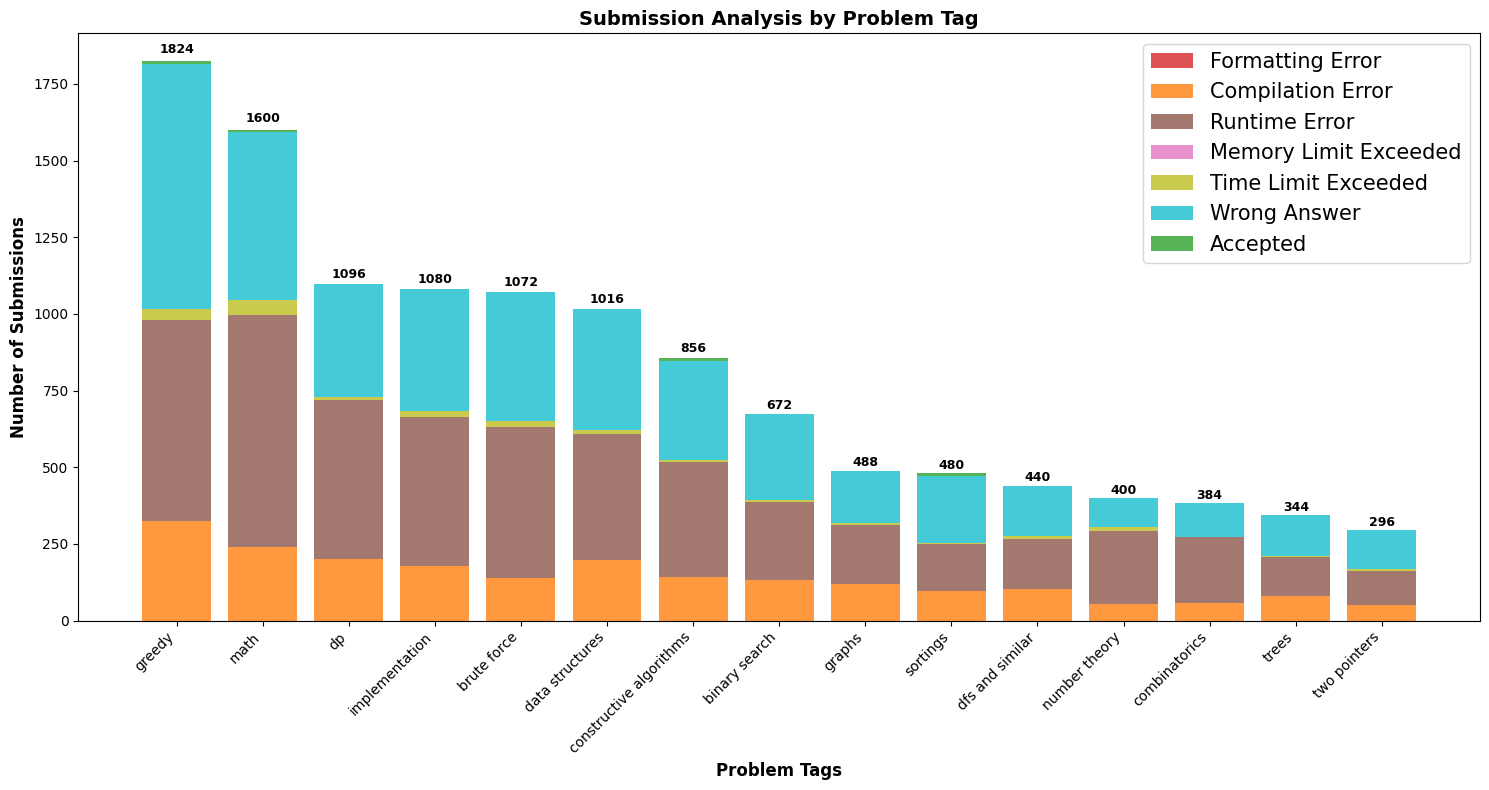

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Get all unique tags
all_tags = set()
for log in all_logs:
    all_tags.update(log['tags'])

print(f"Found {len(all_tags)} unique tags")

# Count submissions by tag and status
tag_status_counts = defaultdict(lambda: defaultdict(int))

for log in all_logs:
    status = log['status']
    tags = log['tags']
    
    # Count for each tag this problem has
    for tag in tags:
        tag_status_counts[tag][status] += 1

# Filter to tags with reasonable number of submissions (>= 20)
min_submissions = 20
filtered_tags = []
for tag in tag_status_counts:
    total = sum(tag_status_counts[tag].values())
    if total >= min_submissions:
        filtered_tags.append((tag, total))

# Sort by total submissions (descending)
filtered_tags.sort(key=lambda x: x[1], reverse=True)
top_tags = [tag for tag, total in filtered_tags[:15]]  # Top 15 tags

# Prepare data for stacked bar chart
statuses = ['FE', 'CE', 'RE', 'MLE', 'TLE', 'WA', 'AC']
status_colors = {
    'FE': '#d62728',    # red
    'CE': '#ff7f0e',    # orange  
    'RE': '#8c564b',    # brown
    'MLE': '#e377c2',   # pink
    'TLE': '#bcbd22',   # olive
    'WA': '#17becf',    # cyan
    'AC': '#2ca02c'     # green
}
status_labels = {
    'FE': 'Formatting Error',
    'CE': 'Compilation Error',
    'RE': 'Runtime Error',
    'MLE': 'Memory Limit Exceeded',
    'TLE': 'Time Limit Exceeded',
    'WA': 'Wrong Answer',
    'AC': 'Accepted'
}

# Create data matrix
data_matrix = []
for status in statuses:
    row = []
    for tag in top_tags:
        count = tag_status_counts[tag][status]
        row.append(count)
    data_matrix.append(row)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(15, 8))

# Calculate positions
x = np.arange(len(top_tags))
width = 0.8

# Create stacked bars
bottom = np.zeros(len(top_tags))
bars = []

for i, status in enumerate(statuses):
    bars.append(ax.bar(x, data_matrix[i], width, bottom=bottom, 
                      label=status, color=status_colors[status], alpha=0.8))
    bottom += data_matrix[i]

# Formatting
ax.set_xlabel('Problem Tags', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Submissions', fontsize=12, fontweight='bold')
ax.set_title('Submission Analysis by Problem Tag', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_tags, rotation=45, ha='right')
legend_labels = [status_labels[status] for status in statuses]
ax.legend(legend_labels, loc='upper right', fontsize=15)

# Add total submission counts on top of bars
for i, tag in enumerate(top_tags):
    total = sum(tag_status_counts[tag].values())
    ax.text(i, total + total*0.01, str(total), ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../figs/base_model/submission_analysis_by_tag.png', dpi=300, bbox_inches='tight')
plt.show()


Rating range: 800 - 3500

Rating bins with >= 10 submissions:
600-899: 552 submissions
900-1199: 376 submissions
1200-1499: 456 submissions
1500-1799: 384 submissions
1800-2099: 408 submissions
2100-2399: 392 submissions
2400-2699: 280 submissions
2700-2999: 336 submissions
3000-3299: 168 submissions
3300-3599: 312 submissions


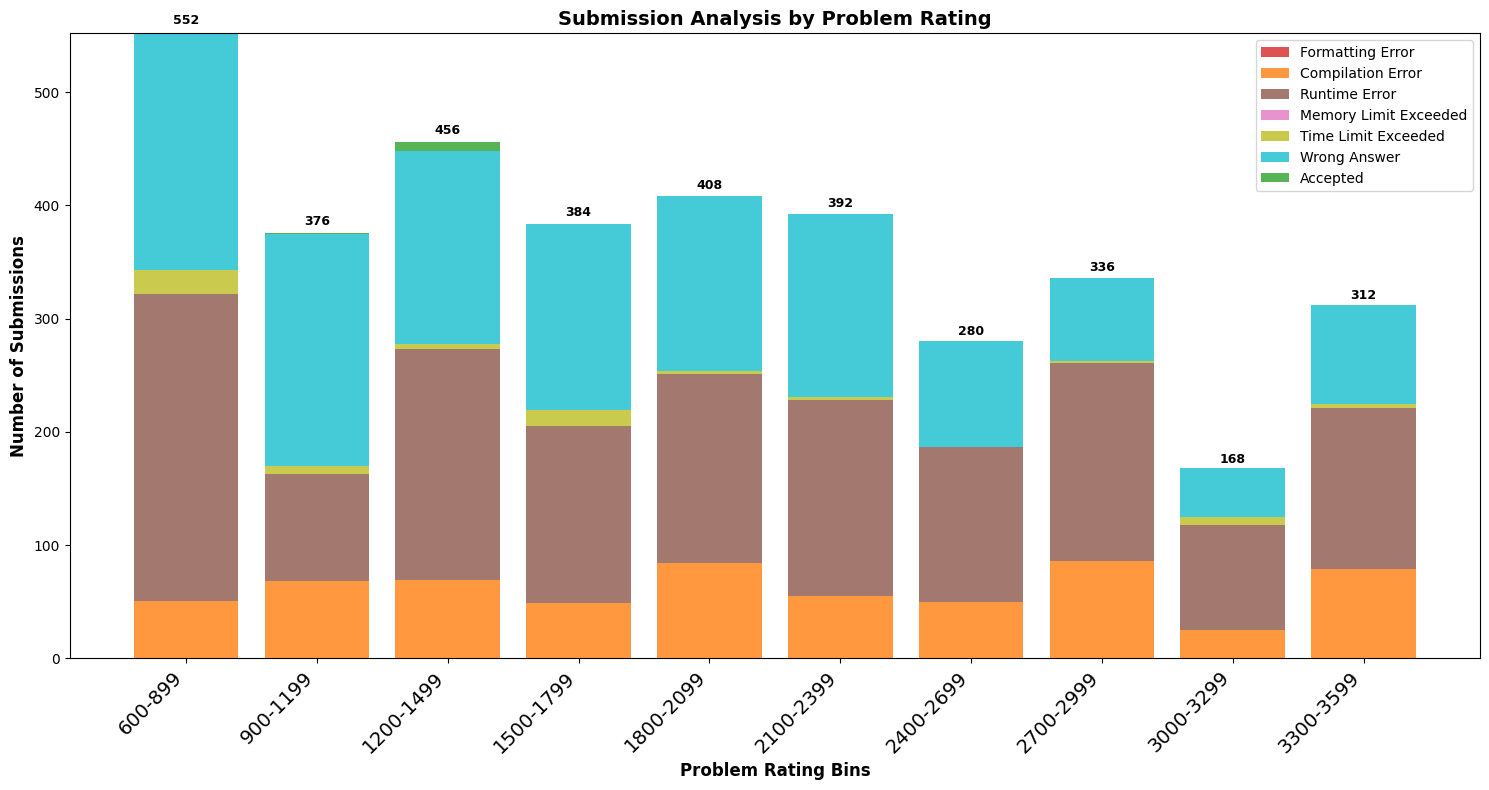

In [112]:
# By rating
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract all ratings and create bins
all_ratings = []
for log in all_logs:
    if log['ratings'] is not None:
        all_ratings.append(log['ratings'])

print(f"Rating range: {min(all_ratings)} - {max(all_ratings)}")

# Create rating bins of 300 points each
def get_rating_bin(rating):
    # Round down to nearest 300
    bin_start = (rating // 300) * 300
    bin_end = bin_start + 299
    return f"{bin_start}-{bin_end}"

# Count submissions by rating bin and status
rating_status_counts = defaultdict(lambda: defaultdict(int))

for log in all_logs:
    status = log['status']
    ratings= log['ratings']
    
    # Count for each rating this problem has
    if ratings is not None:
        bin_name = get_rating_bin(ratings)
        rating_status_counts[bin_name][status] += 1

# Filter to bins with reasonable number of submissions (>= 10) and sort by bin start value
min_submissions = 10
filtered_bins = []
for bin_name in rating_status_counts:
    total = sum(rating_status_counts[bin_name].values())
    if total >= min_submissions:
        bin_start = int(bin_name.split('-')[0])
        filtered_bins.append((bin_name, bin_start, total))

# Sort by bin start value (ascending)
filtered_bins.sort(key=lambda x: x[1])
rating_bins = [bin_name for bin_name, _, total in filtered_bins]

print(f"\nRating bins with >= {min_submissions} submissions:")
for bin_name, _, total in filtered_bins:
    print(f"{bin_name}: {total} submissions")

# Prepare data for stacked bar chart
statuses = ['FE', 'CE', 'RE', 'MLE', 'TLE', 'WA', 'AC']
status_colors = {
    'FE': '#d62728',    # red
    'CE': '#ff7f0e',    # orange  
    'RE': '#8c564b',    # brown
    'MLE': '#e377c2',   # pink
    'TLE': '#bcbd22',   # olive
    'WA': '#17becf',    # cyan
    'AC': '#2ca02c'     # green
}
status_labels = {
    'FE': 'Formatting Error',
    'CE': 'Compilation Error',
    'RE': 'Runtime Error',
    'MLE': 'Memory Limit Exceeded',
    'TLE': 'Time Limit Exceeded',
    'WA': 'Wrong Answer',
    'AC': 'Accepted'
}

# Create data matrix
data_matrix = []
for status in statuses:
    row = []
    for bin_name in rating_bins:
        count = rating_status_counts[bin_name][status]
        row.append(count)
    data_matrix.append(row)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(15, 8))

# Calculate positions
x = np.arange(len(rating_bins))
width = 0.8

# Create stacked bars
bottom = np.zeros(len(rating_bins))
bars = []

for i, status in enumerate(statuses):
    bars.append(ax.bar(x, data_matrix[i], width, bottom=bottom, 
                      label=status, color=status_colors[status], alpha=0.8))
    bottom += data_matrix[i]

# Formatting
ax.set_xlabel('Problem Rating Bins', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Submissions', fontsize=12, fontweight='bold')
ax.set_title('Submission Analysis by Problem Rating', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(rating_bins, rotation=45, ha='right', fontsize=14)
legend_labels = [status_labels[status] for status in statuses]
ax.legend(legend_labels, loc='upper right', fontsize=10)

# Add total submission counts on top of bars
for i, bin_name in enumerate(rating_bins):
    total = sum(rating_status_counts[bin_name].values())
    ax.text(i, total + total*0.01, str(total), ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../figs/base_model/submission_analysis_by_rating.png', dpi=300, bbox_inches='tight')
plt.show()


Top 15 tags:
greedy: 1824
math: 1600
dp: 1096
implementation: 1080
brute force: 1072
data structures: 1016
constructive algorithms: 856
binary search: 672
graphs: 488
sortings: 480
dfs and similar: 440
number theory: 400
combinatorics: 384
trees: 344
two pointers: 296

Rating bins: ['800-999', '1000-1199', '1200-1399', '1400-1599', '1600-1799', '1800-1999', '2000-2199', '2200-2399', '2400-2599', '2600-2799', '2800-2999', '3000-3199', '3200-3399', '3400-3599']


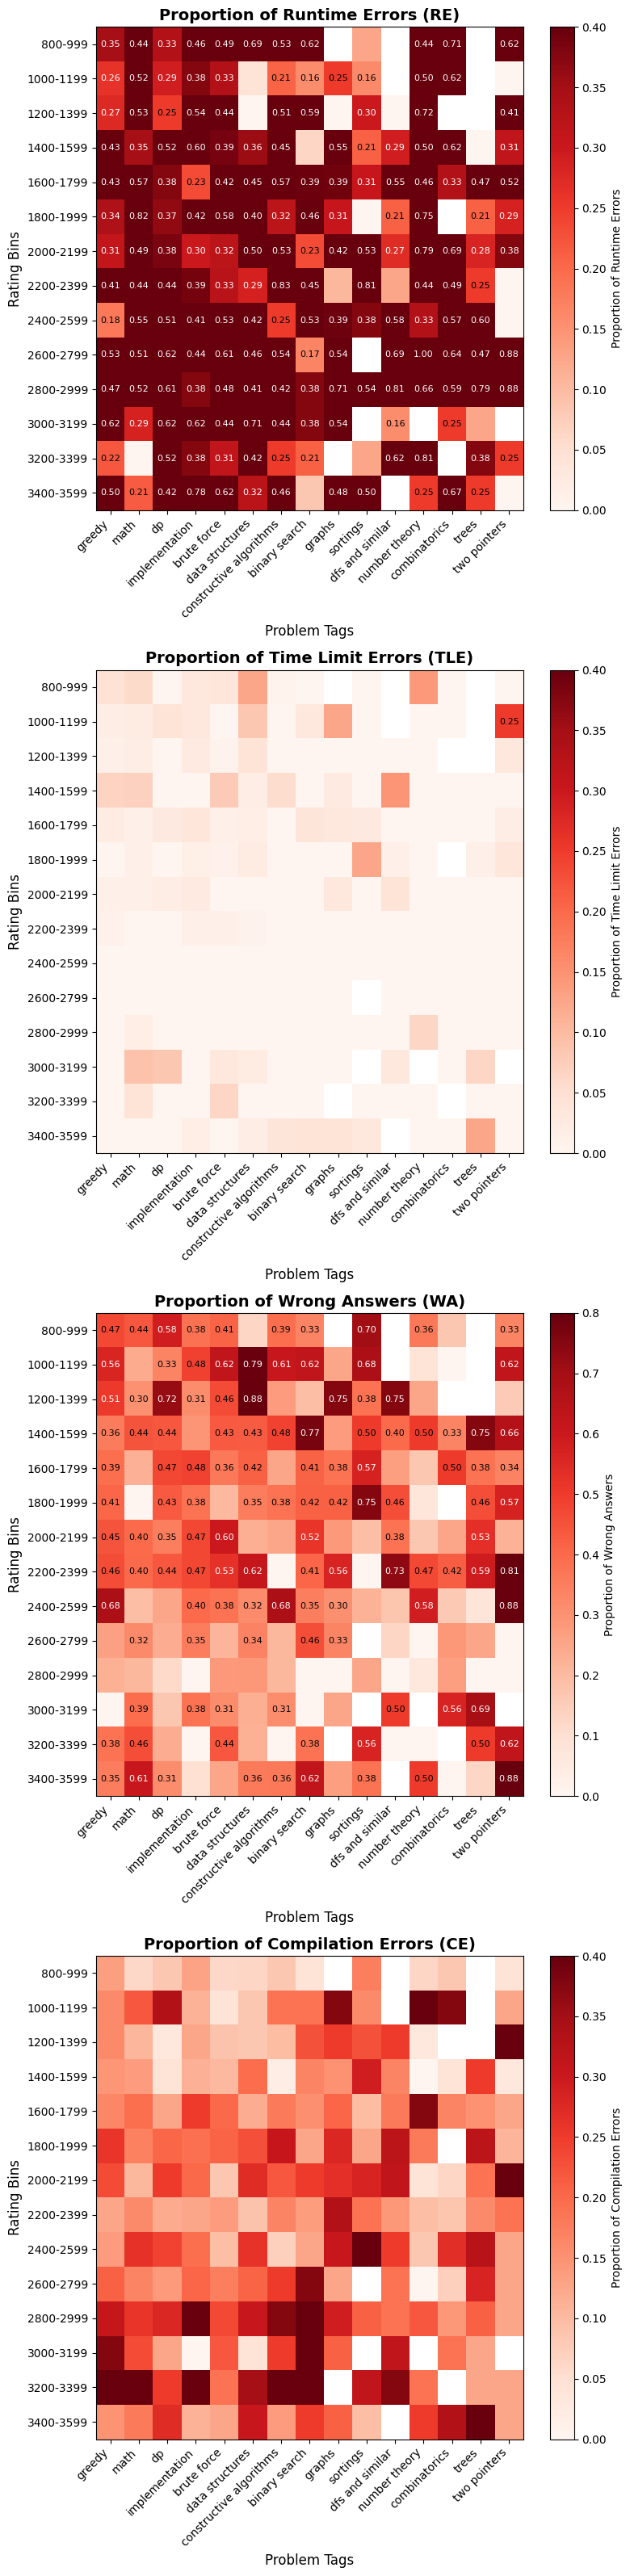


Highest error proportions:
Highest RE: 2600-2799 + number theory: 1.000
Highest TLE: 1000-1199 + two pointers: 0.250
Highest WA: 1200-1399 + data structures: 0.875


In [118]:
#Heatmap showing proportion of RE, TLE, and WA by rating vs tag
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Create rating bins of 200 points each for better granularity
def get_rating_bin(rating):
    bin_start = (rating // 200) * 200
    return f"{bin_start}-{bin_start+199}"

# Get most common tags (top 15)
tag_counts = defaultdict(int)
for log in all_logs:
    for tag in log['tags']:
        tag_counts[tag] += 1

top_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:15]
top_tag_names = [tag for tag, count in top_tags]

print("Top 15 tags:")
for tag, count in top_tags:
    print(f"{tag}: {count}")

# Count submissions by rating bin, tag, and status
rating_tag_status = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for log in all_logs:
    status = log['status']
    tags = log['tags']
    ratings = log['ratings']
    
    # For each rating-tag combination in this submission
    if ratings is not None:
        
        rating_bin = get_rating_bin(ratings)
        for tag in tags:
            if tag in top_tag_names:  # Only consider top tags
                rating_tag_status[rating_bin][tag][status] += 1

# Get all rating bins that appear
all_rating_bins = sorted(rating_tag_status.keys(), 
                        key=lambda x: int(x.split('-')[0]))

print(f"\nRating bins: {all_rating_bins}")

# Create matrices for the three error types
min_submissions = 5  # Minimum submissions for a cell to be considered

def create_proportion_matrix(target_status):
    matrix = []
    valid_mask = []
    
    for rating_bin in all_rating_bins:
        row = []
        mask_row = []
        
        for tag in top_tag_names:
            total = sum(rating_tag_status[rating_bin][tag].values())
            target_count = rating_tag_status[rating_bin][tag][target_status]
            
            if total >= min_submissions:
                proportion = target_count / total
                row.append(proportion)
                mask_row.append(False)  # Valid cell
            else:
                row.append(0)  # Will be masked
                mask_row.append(True)   # Invalid cell (too few submissions)
        
        matrix.append(row)
        valid_mask.append(mask_row)
    
    return np.array(matrix), np.array(valid_mask)

# Create matrices for RE, TLE, WA
ce_matrix, ce_mask = create_proportion_matrix('CE')
re_matrix, re_mask = create_proportion_matrix('RE')
tle_matrix, tle_mask = create_proportion_matrix('TLE')
wa_matrix, wa_mask = create_proportion_matrix('WA')


# Create the three heatmaps
fig, axes = plt.subplots(4, 1, figsize=(8, 32))

# Define color maps
cmap = 'Reds'

# Runtime Error heatmap
masked_re = np.ma.masked_array(re_matrix, mask=re_mask)
im1 = axes[0].imshow(masked_re, cmap=cmap, aspect='auto', vmin=0, vmax=0.4)
axes[0].set_title('Proportion of Runtime Errors (RE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Problem Tags', fontsize=12)
axes[0].set_ylabel('Rating Bins', fontsize=12)
axes[0].set_xticks(range(len(top_tag_names)))
axes[0].set_xticklabels(top_tag_names, rotation=45, ha='right')
axes[0].set_yticks(range(len(all_rating_bins)))
axes[0].set_yticklabels(all_rating_bins)
plt.colorbar(im1, ax=axes[0], label='Proportion of Runtime Errors')

# Time Limit Error heatmap  
masked_tle = np.ma.masked_array(tle_matrix, mask=tle_mask)
im2 = axes[1].imshow(masked_tle, cmap=cmap, aspect='auto', vmin=0, vmax=0.4)
axes[1].set_title('Proportion of Time Limit Errors (TLE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Problem Tags', fontsize=12)
axes[1].set_ylabel('Rating Bins', fontsize=12)
axes[1].set_xticks(range(len(top_tag_names)))
axes[1].set_xticklabels(top_tag_names, rotation=45, ha='right')
axes[1].set_yticks(range(len(all_rating_bins)))
axes[1].set_yticklabels(all_rating_bins)
plt.colorbar(im2, ax=axes[1], label='Proportion of Time Limit Errors')

# Wrong Answer heatmap
masked_wa = np.ma.masked_array(wa_matrix, mask=wa_mask)
im3 = axes[2].imshow(masked_wa, cmap=cmap, aspect='auto', vmin=0, vmax=0.8)
axes[2].set_title('Proportion of Wrong Answers (WA)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Problem Tags', fontsize=12)
axes[2].set_ylabel('Rating Bins', fontsize=12)
axes[2].set_xticks(range(len(top_tag_names)))
axes[2].set_xticklabels(top_tag_names, rotation=45, ha='right')
axes[2].set_yticks(range(len(all_rating_bins)))
axes[2].set_yticklabels(all_rating_bins)
plt.colorbar(im3, ax=axes[2], label='Proportion of Wrong Answers')

# Compilation Error heatmap
masked_ce = np.ma.masked_array(ce_matrix, mask=ce_mask)
im4 = axes[3].imshow(masked_ce, cmap=cmap, aspect='auto', vmin=0, vmax=0.4)
axes[3].set_title('Proportion of Compilation Errors (CE)', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Problem Tags', fontsize=12)
axes[3].set_ylabel('Rating Bins', fontsize=12)
axes[3].set_xticks(range(len(top_tag_names)))
axes[3].set_xticklabels(top_tag_names, rotation=45, ha='right')
axes[3].set_yticks(range(len(all_rating_bins)))
axes[3].set_yticklabels(all_rating_bins)
plt.colorbar(im4, ax=axes[3], label='Proportion of Compilation Errors')

# Add text annotations for values > threshold
for i in range(len(all_rating_bins)):
    for j in range(len(top_tag_names)):
        if not re_mask[i, j] and re_matrix[i, j] > 0.15:
            axes[0].text(j, i, f'{re_matrix[i, j]:.2f}', ha='center', va='center', 
                        color='white' if re_matrix[i, j] > 0.25 else 'black', fontsize=8)
        if not tle_mask[i, j] and tle_matrix[i, j] > 0.15:
            axes[1].text(j, i, f'{tle_matrix[i, j]:.2f}', ha='center', va='center',
                        color='white' if tle_matrix[i, j] > 0.25 else 'black', fontsize=8)
        if not wa_mask[i, j] and wa_matrix[i, j] > 0.3:
            axes[2].text(j, i, f'{wa_matrix[i, j]:.2f}', ha='center', va='center',
                        color='white' if wa_matrix[i, j] > 0.5 else 'black', fontsize=8)

plt.tight_layout()
plt.savefig('../figs/base_model/error_proportion_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Print insights
print(f"\nHighest error proportions:")

re_flat = masked_re.compressed()
if len(re_flat) > 0:
    max_re_idx = np.unravel_index(np.ma.argmax(masked_re), re_matrix.shape)
    print(f"Highest RE: {all_rating_bins[max_re_idx[0]]} + {top_tag_names[max_re_idx[1]]}: {re_matrix[max_re_idx]:.3f}")

tle_flat = masked_tle.compressed()
if len(tle_flat) > 0:
    max_tle_idx = np.unravel_index(np.ma.argmax(masked_tle), tle_matrix.shape)
    print(f"Highest TLE: {all_rating_bins[max_tle_idx[0]]} + {top_tag_names[max_tle_idx[1]]}: {tle_matrix[max_tle_idx]:.3f}")

wa_flat = masked_wa.compressed()
if len(wa_flat) > 0:
    max_wa_idx = np.unravel_index(np.ma.argmax(masked_wa), wa_matrix.shape)
    print(f"Highest WA: {all_rating_bins[max_wa_idx[0]]} + {top_tag_names[max_wa_idx[1]]}: {wa_matrix[max_wa_idx]:.3f}")